In [4]:
import pykoop
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint, solve_ivp
import seaborn as sns

In [5]:
seed = 100
np.random.seed(seed)

In [6]:
def deriv(t, y):
    pos = y[:2*N].reshape(N,2)
    vel = y[2*N:].reshape(N,2)
    acc = np.zeros_like(pos)
    # 弹簧力
    for i,j,k_ij in springs:
        diff = pos[i] - pos[j]
        d = np.linalg.norm(diff)
        if d == 0:
            continue
        force = -k_ij*(d - L[(i,j)]) * (diff/d)
        acc[i] += force/m
        acc[j] -= force/m  # 反作用
    dydt = np.concatenate([vel.flatten(), acc.flatten()])
    return dydt

In [92]:
# 参数定义
N = 2  # 振子数量
m = 1.0  # 质量
k_strong = 50.0
k_weak = 1

# 振子分组
groups = {0:'a',1:'b'}
springs = []  # (i, j, k_ij)

for i in range(N):
    for j in range(N):
        if i <= j :
            if groups[i] == groups[j]:
                springs.append((i, j, k_strong))
            else:
                springs.append((i, j, k_weak))

# 初始位置
pos_init = np.array([[-0.5, 0.0], [0.5, -0.0]])
pos_init += np.random.randn(N,2)*0.1  # 加一点扰动

# 计算自然长度
L = {}
for i,j,k in springs:
    if groups[i] == groups[j]:
        L[(i,j)] = 0.5 
    else:
        L[(i,j)] = 3

# 初始速度
vel_init = np.zeros((N,2))

# 状态展开
y0 = np.concatenate([pos_init.flatten(), vel_init.flatten()])

# 积分
t_span = [0, 100]
t_eval = np.linspace(0, 100, 10000)
sol = solve_ivp(deriv, t_span, y0, t_eval=t_eval)
#sol = solve_ivp(deriv, t_span, y0, t_eval=t_eval, method='RK45')

# 提取轨迹数据
traj = sol.y[:2*N,:].reshape(N,2,-1)
vels = sol.y[2*N:,:].reshape(N,2,-1)

# 将所有振子的位置和速度展平为单一数据矩阵
# 数据格式: [x1, y1, x2, y2, x3, y3, x4, y4, x5, y5, x6, y6, vx1, vy1, ..., vx6, vy6]
positions = traj.reshape(N*2, -1).T  # 形状: (10000, 12)
velocities = vels.reshape(N*2, -1).T  # 形状: (10000, 12)

# 合并位置和速度数据
data_noiseless = np.hstack([positions, velocities])  # 形状: (10000, 24)

# 添加微小噪声（与SIR实验相同）
noise_mean = 0.0
noise_std = 0.001
noise = noise_mean + np.random.randn(*data_noiseless.shape) * noise_std
data_noisy = data_noiseless + noise

data = data_noisy
t = t_eval

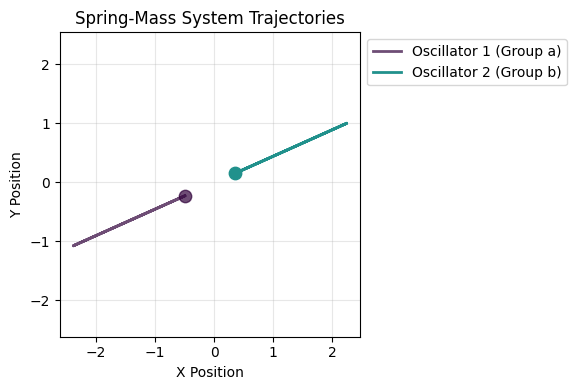

In [93]:
# 1. 轨迹图和速度模长图
unique_groups = sorted(list(set(groups.values()))) 
color_map = {group: plt.cm.viridis(i/len(unique_groups)) for i, group in enumerate(unique_groups)}
oscillator_colors = plt.cm.tab10(np.arange(6))  # 每个振子不同颜色
fig, ax = plt.subplots(figsize=(6, 4))

# 绘制每个振子的轨迹
for i in range(N):
    group = groups[i]
    base_color = color_map[group]  # 基于组的基础颜色
    
    # 调整亮度生成振子专属颜色（保持在0-1范围内）
    oscillator_color = np.array(base_color) * (0.7 + 0.3 * (i % 3))
    oscillator_color = np.clip(oscillator_color, 0, 1)
    
    # 使用ax对象绘图（统一使用子图对象，避免plt和ax混用）
    ax.plot(traj[i, 0, :], traj[i, 1, :], 
            color=oscillator_color, linewidth=2,
            label=f'Oscillator {i+1} (Group {group})')
    
    # 绘制轨迹起点（用更大的点标记）
    ax.scatter(traj[i, 0, 0], traj[i, 1, 0], 
               color=oscillator_color, s=80, zorder=10, marker='o')

# 设置图形属性
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_title('Spring-Mass System Trajectories')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))  # 图例放在图外避免遮挡
ax.grid(True, alpha=0.3)
ax.axis('equal')  # 等比例显示，避免轨迹变形

plt.tight_layout()
plt.show()


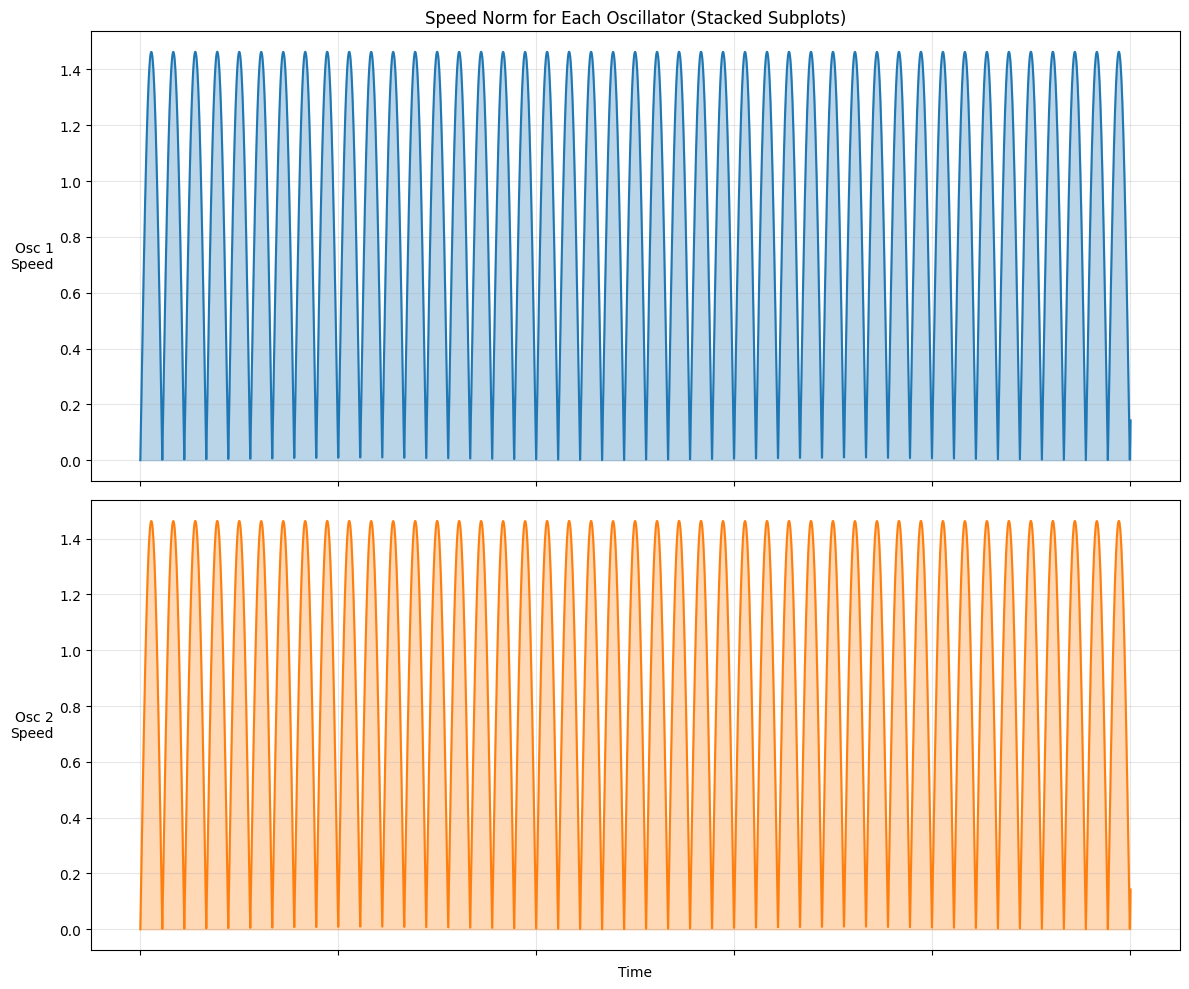

In [94]:
# 多个子图叠层显示
fig, axes = plt.subplots(N, 1, figsize=(12, 10), sharex=True)

vnorm = np.linalg.norm(vels, axis=1)

for i in range(N):
    ax = axes[i]
    ax.plot(t, vnorm[i], color=oscillator_colors[i], linewidth=1.5)
    ax.fill_between(t, 0, vnorm[i], color=oscillator_colors[i], alpha=0.3)
    ax.set_ylabel(f'Osc {i+1}\nSpeed', rotation=0, ha='right', va='center')
    ax.grid(True, alpha=0.3)
    
    # 只在最下面的图显示x轴标签
    if i == N-1:
        ax.set_xlabel('Time')
    else:
        ax.set_xticklabels([])

axes[0].set_title('Speed Norm for Each Oscillator (Stacked Subplots)')
plt.tight_layout()
plt.show()

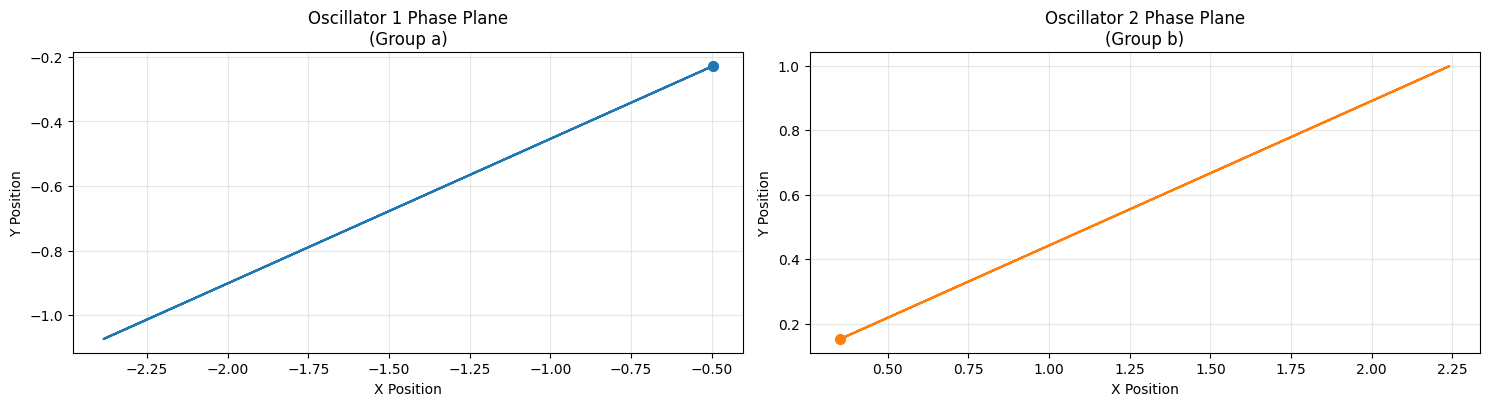

In [95]:
# 2. 每个振子的相平面图（位置X vs 位置Y）
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes = axes.flatten()

for i in range(N):
    ax = axes[i]
    color = oscillator_colors[i]
    
    # 绘制相平面轨迹
    ax.plot(traj[i, 0, :], traj[i, 1, :], color=color, linewidth=1.5)
    ax.scatter(traj[i, 0, 0], traj[i, 1, 0], color=color, s=50, marker='o', zorder=10)
    
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_title(f'Oscillator {i+1} Phase Plane\n(Group {groups[i]})')
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()

In [96]:
print("训练Koopman模型...")
kp = pykoop.KoopmanPipeline(
    lifting_functions=[
        ('pl', pykoop.PolynomialLiftingFn(order=1)),
        ('ss', pykoop.SkLearnLiftingFn(StandardScaler()))
    ],
    regressor=pykoop.Edmd(alpha=0.5),
)

# 训练Koopman模型（弹簧振子数据没有外部输入）
kp.fit(data, n_inputs=0)

训练Koopman模型...


KoopmanPipeline(lifting_functions=[('pl', PolynomialLiftingFn()),
                                   ('ss',
                                    SkLearnLiftingFn(transformer=StandardScaler()))],
                regressor=Edmd(alpha=0.5))

In [97]:
# 模型预测和评估
p_steps = 1000  # 预测步数
X_test = data[:p_steps, :]  # 使用前1000个点作为测试数据

print("进行轨迹预测...")

pred = kp.predict_trajectory(X_test, None)

进行轨迹预测...


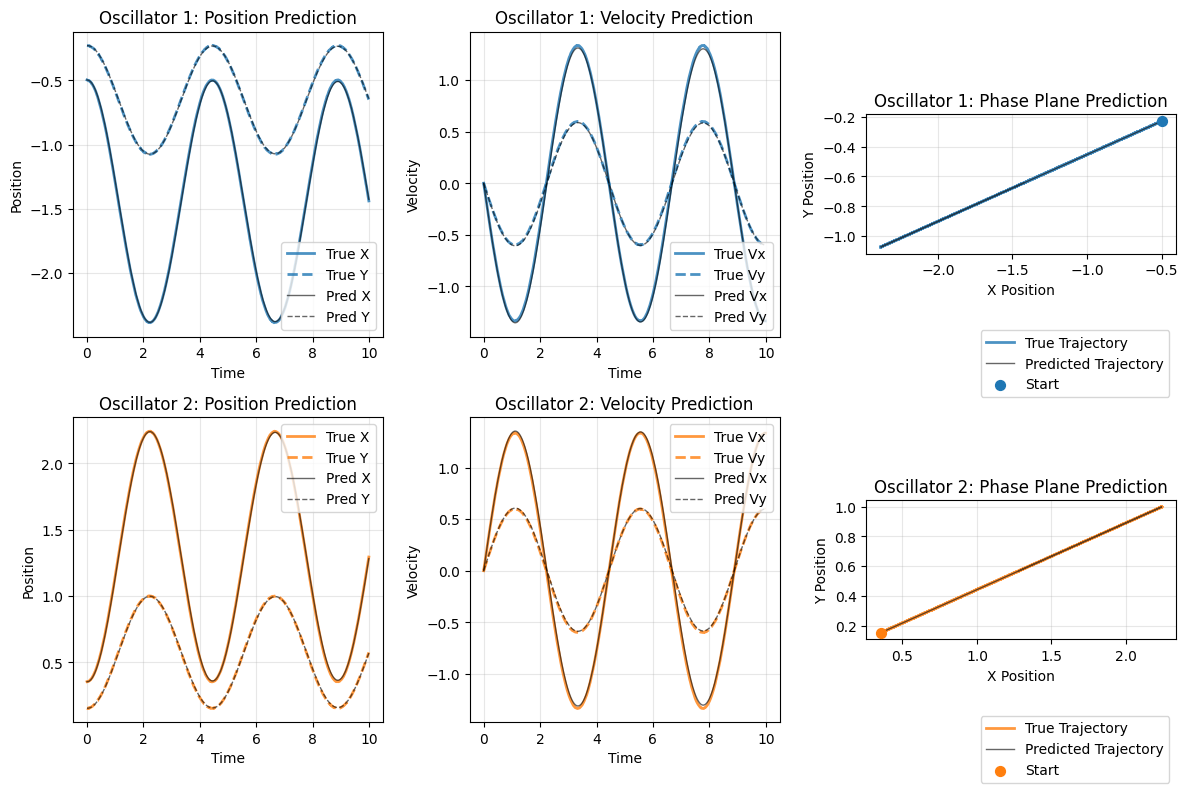

In [100]:
# 3. 预测结果可视化 - 每行三个图，每个振子一列
n_oscillators = N  # 振子数量
fig, axes = plt.subplots(n_oscillators, 3, figsize=(12, 4*n_oscillators))

# 如果只有一个振子，调整axes形状
if n_oscillators == 1:
    axes = axes.reshape(1, -1)

for i in range(n_oscillators):
    # 计算数据中的列索引
    pos_x_idx = i * 2          # 位置X列索引
    pos_y_idx = i * 2 + 1      # 位置Y列索引  
    vel_x_idx = N*2 + i * 2     # 速度X列索引（后12列是速度）
    vel_y_idx = N*2 + i * 2 + 1 # 速度Y列索引
    
    color = oscillator_colors[i]
    
    # 第一个图：X和Y位置预测
    ax1 = axes[i, 0]
    # 真实值
    ax1.plot(t[:p_steps], X_test[:, pos_x_idx], color=color, linewidth=2, 
             label=f'True X', alpha=0.8)
    ax1.plot(t[:p_steps], X_test[:, pos_y_idx], color=color, linewidth=2, 
             linestyle='--', label=f'True Y', alpha=0.8)
    # 预测值
    ax1.plot(t[:p_steps], pred[:, pos_x_idx], 'k-', linewidth=1, 
             label='Pred X', alpha=0.6)
    ax1.plot(t[:p_steps], pred[:, pos_y_idx], 'k--', linewidth=1, 
             label='Pred Y', alpha=0.6)
    
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Position')
    ax1.set_title(f'Oscillator {i+1}: Position Prediction')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 第二个图：X和Y速度预测
    ax2 = axes[i, 1]
    # 真实值
    ax2.plot(t[:p_steps], X_test[:, vel_x_idx], color=color, linewidth=2, 
             label=f'True Vx', alpha=0.8)
    ax2.plot(t[:p_steps], X_test[:, vel_y_idx], color=color, linewidth=2, 
             linestyle='--', label=f'True Vy', alpha=0.8)
    # 预测值
    ax2.plot(t[:p_steps], pred[:, vel_x_idx], 'k-', linewidth=1, 
             label='Pred Vx', alpha=0.6)
    ax2.plot(t[:p_steps], pred[:, vel_y_idx], 'k--', linewidth=1, 
             label='Pred Vy', alpha=0.6)
    
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Velocity')
    ax2.set_title(f'Oscillator {i+1}: Velocity Prediction')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 第三个图：相平面预测
    ax3 = axes[i, 2]
    # 真实轨迹
    ax3.plot(X_test[:, pos_x_idx], X_test[:, pos_y_idx], color=color, 
             linewidth=2, label='True Trajectory', alpha=0.8)
    # 预测轨迹
    ax3.plot(pred[:, pos_x_idx], pred[:, pos_y_idx], 'k-', linewidth=1, 
             label='Predicted Trajectory', alpha=0.6)
    # 起点标记
    ax3.scatter(X_test[0, pos_x_idx], X_test[0, pos_y_idx], color=color, 
                s=50, marker='o', zorder=10, label='Start')
    
    ax3.set_xlabel('X Position')
    ax3.set_ylabel('Y Position')
    ax3.set_title(f'Oscillator {i+1}: Phase Plane Prediction')
    ax3.legend(bbox_to_anchor=(1, -0.5))
    ax3.grid(True, alpha=0.3)
    ax3.set_aspect('equal')

plt.tight_layout()
plt.show()

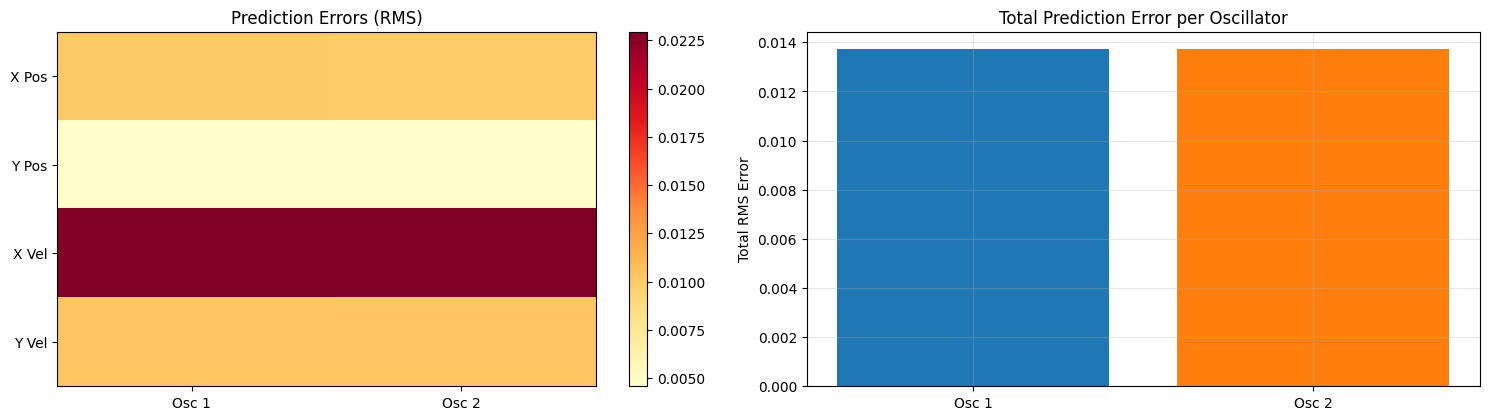

In [101]:
# 4. 预测误差热力图（所有振子的综合视图）
prediction_errors = np.abs(X_test - pred[:len(X_test)])

# 按振子组织误差数据
oscillator_errors = []
for i in range(N):
    pos_errors = prediction_errors[:, i*2:(i+1)*2]  # 位置误差
    vel_errors = prediction_errors[:, N*2+i*2:N*2+(i+1)*2]  # 速度误差
    oscillator_errors.append({
        'position_rms': np.sqrt(np.mean(pos_errors**2, axis=0)),
        'velocity_rms': np.sqrt(np.mean(vel_errors**2, axis=0)),
        'total_rms': np.sqrt(np.mean(np.concatenate([pos_errors, vel_errors])**2))
    })

# 创建误差热力图
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
axes = axes.flatten()

error_matrix = np.array([[err['position_rms'][0], err['position_rms'][1], 
                         err['velocity_rms'][0], err['velocity_rms'][1]] 
                        for err in oscillator_errors])

im = axes[0].imshow(error_matrix.T, cmap='YlOrRd', aspect='auto')
axes[0].set_xticks(range(N))
axes[0].set_xticklabels([f'Osc {i+1}' for i in range(N)])
axes[0].set_yticks(range(4))
axes[0].set_yticklabels(['X Pos', 'Y Pos', 'X Vel', 'Y Vel'])
axes[0].set_title('Prediction Errors (RMS)')
plt.colorbar(im, ax=axes[0])

# 总误差条形图
total_errors = [err['total_rms'] for err in oscillator_errors]
axes[1].bar(range(N), total_errors, color=oscillator_colors)
axes[1].set_xticks(range(N))
axes[1].set_xticklabels([f'Osc {i+1}' for i in range(N)])
axes[1].set_ylabel('Total RMS Error')
axes[1].set_title('Total Prediction Error per Oscillator')
axes[1].grid(True, alpha=0.3)

# 隐藏多余的子图
for i in range(2, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

(<Figure size 640x480 with 2 Axes>, <Axes: >)

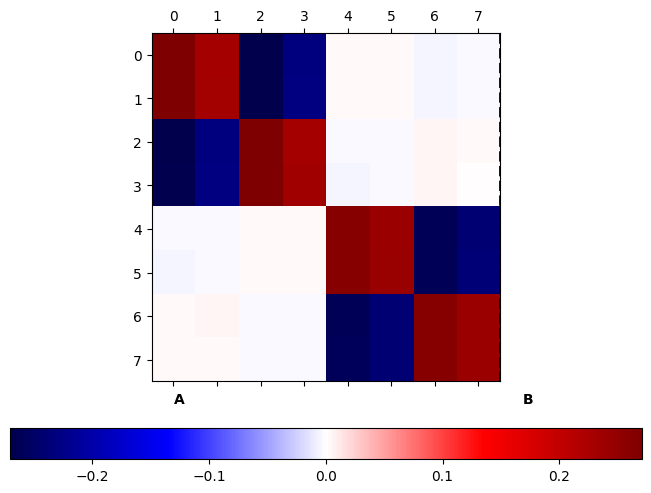

In [102]:
kp.regressor_.plot_koopman_matrix()

In [103]:
A = kp.regressor_.coef_
A

array([[ 0.2696908 ,  0.27051608, -0.26957771, -0.26816406, -0.0033935 ,
        -0.00475546,  0.0028807 ,  0.00339455],
       [ 0.2299646 ,  0.2317557 , -0.23117969, -0.22931209, -0.00388154,
        -0.00385423,  0.00507077,  0.00406786],
       [-0.26980955, -0.26874427,  0.27039841,  0.26913465,  0.00299943,
         0.00288487, -0.00256015, -0.00330162],
       [-0.23042272, -0.22886699,  0.22873255,  0.2332728 ,  0.00388694,
         0.00266522, -0.00363735, -0.00341399],
       [ 0.00305917,  0.00412789, -0.00340074, -0.0046926 ,  0.26017929,
         0.26075735, -0.26056581, -0.25982144],
       [ 0.00404424,  0.00230868, -0.00349418, -0.0032202 ,  0.23965316,
         0.24145067, -0.23966276, -0.24018043],
       [-0.00440756, -0.00473016,  0.004816  ,  0.00431147, -0.26019803,
        -0.26096383,  0.2605147 ,  0.26052141],
       [-0.00261937, -0.00299141,  0.00239617,  0.00192011, -0.23985732,
        -0.23671368,  0.23914473,  0.23936203]])

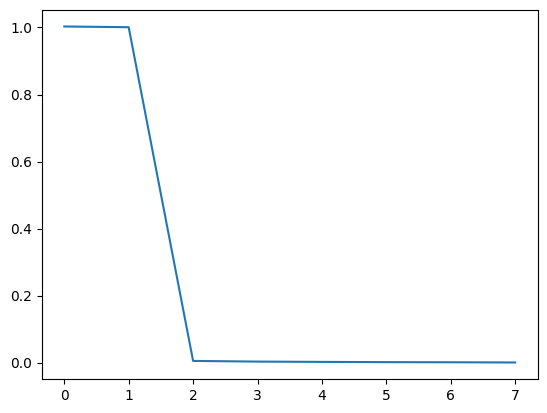

In [104]:
U,S,V = np.linalg.svd(A)
plt.figure()
plt.plot(S)
plt.show()

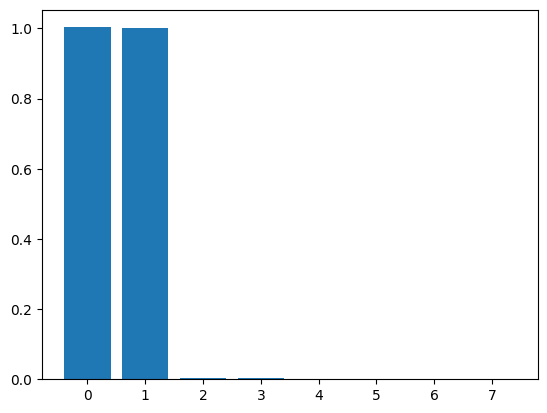

In [105]:
plt.figure()
# 绘制柱状图，x轴为奇异值的索引（从0开始），y轴为奇异值大小
plt.bar(range(len(S)), S)
plt.show()

In [106]:
S

array([1.00304130e+00, 1.00086389e+00, 4.88550444e-03, 2.86769895e-03,
       1.98367236e-03, 1.23688926e-03, 8.77815434e-04, 2.38598418e-04])

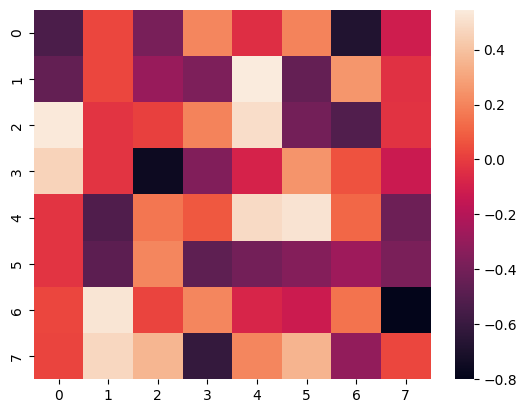

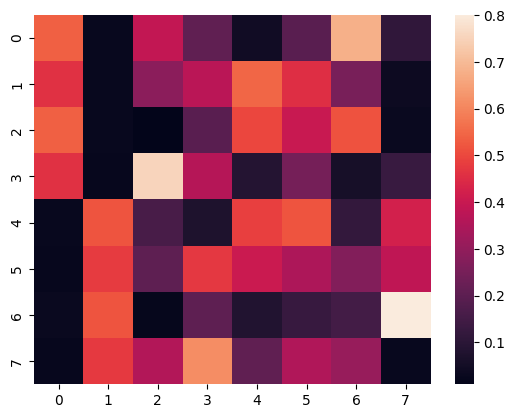

In [107]:
U_abs = np.abs(U)
plt.figure()
sns.heatmap(U)
plt.show()
plt.figure()
sns.heatmap(U_abs)
plt.show()

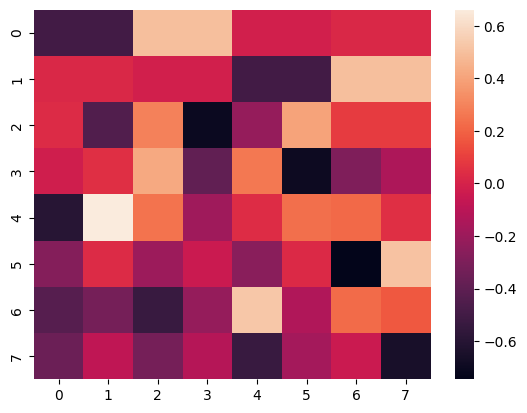

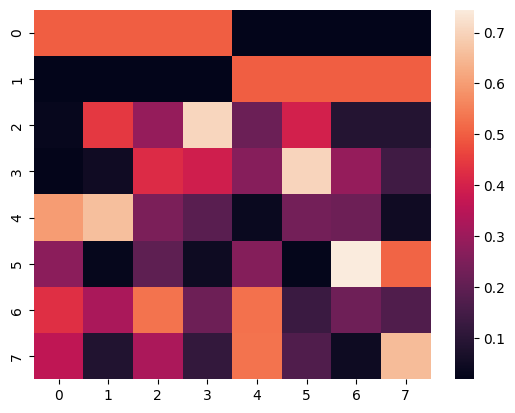

In [108]:
V_abs = np.abs(V)
plt.figure()
sns.heatmap(V)
plt.show()
plt.figure()
sns.heatmap(V_abs)
plt.show()